# Business Understanding


<details>
<summary>📌 Klik untuk melihat penjelasan</summary>

Hotel sering sekali mengalami kerugian akibat tingginya tingkat pembatalan reservasi oleh para tamu. 
Tujuan proyek ini dibuat adalah untuk membangun model machine learning yang dapat memprediksi kemungkinan pembatalan reservasi oleh tamu.  

Dengan prediksi ini, hotel dapat:  
- Mengantisipasi kerugian besar akibat kamar kosong  
- Menerapkan kebijakan deposit tambahan untuk tamu  
- strategi overbooking yang aman  

</details>


## Import Library

In [2]:
import pandas as pd
import numpy as np

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Evaluation
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
import pickle


# Data Understanding


<details>
<summary>📊 Klik untuk melihat detail</summary>

Dataset: **Hotel Booking Demand**  
- Jumlah data: 83.573 baris, 32 kolom  
- Target: `is_canceled` (1 = dibatalkan, 0 = tidak dibatalkan)  
- Beberapa fitur penting:  
  - `country`, `market_segment`, `deposit_type`, `reserved_room_type`  
  - `previous_cancellations`, `booking_changes`, `days_in_waiting_list`, `customer_type`, `required_car_parking_space`, `total_of_special_request`

</details>


In [3]:
# Load dataset
df = pd.read_csv("data_hotel_booking_demand.csv")

print("Ukuran dataset:", df.shape)
df.head()


Ukuran dataset: (83573, 11)


,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,0
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0
3,NLD,Online TA,0,0,No Deposit,0,Transient,A,0,1,1
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,0


In [4]:
# Cek missing values
df.isnull().sum()


country                        351
market_segment                   0
previous_cancellations           0
booking_changes                  0
deposit_type                     0
days_in_waiting_list             0
customer_type                    0
reserved_room_type               0
required_car_parking_spaces      0
total_of_special_requests        0
is_canceled                      0
dtype: int64

# Data Preparation


In [5]:
# Isi missing values pada kolom 'country'
df['country'] = df['country'].fillna("Unknown")

# Tentukan target dan fitur
target = "is_canceled"
X = df.drop(target, axis=1)
y = df[target]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Pilih fitur numerik & kategorikal 
cat_features = ["country", "market_segment", "deposit_type", "customer_type", "reserved_room_type"]
num_features = ["previous_cancellations", "booking_changes", "days_in_waiting_list", "required_car_parking_spaces", "total_of_special_requests"]

# Preprocessor (OneHotEncoder untuk categorical & StandardScaler untuk numeric)
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown='ignore'), cat_features),
    ("num", StandardScaler(), num_features)
])


# Modeling


In [6]:
# Definisi model
models = {
"Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced"),
"Random Forest": RandomForestClassifier(class_weight="balanced", random_state=42),
"Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

# Simpan hasil
results = []

for name, model in models.items():
    pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", model)])
    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:,1]
    
    results.append({
        "Model": name,
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_proba)
    })

results_df = pd.DataFrame(results)
results_df


,Model,Precision,Recall,F1-Score,ROC-AUC
0,Logistic Regression,0.688459,0.750975,0.718359,0.864289
1,Random Forest,0.695104,0.788824,0.739005,0.891074
2,Gradient Boosting,0.817455,0.597953,0.690684,0.885930


<details>
<summary>🤖 Klik untuk melihat code</summary>

```python
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score

models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]
    results[name] = {
        "classification_report": classification_report(y_test, y_pred, output_dict=True),
        "roc_auc": roc_auc_score(y_test, y_prob)
    }

results


# Evaluation


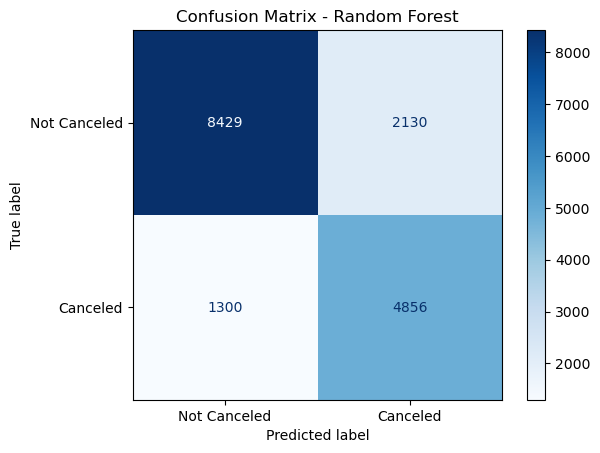

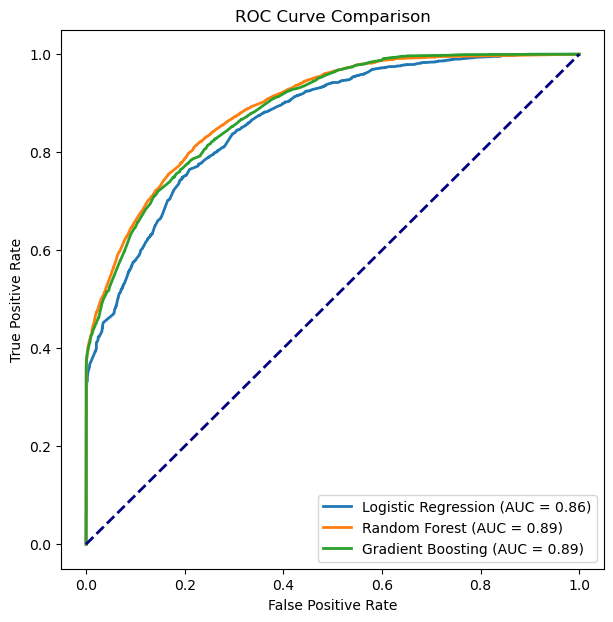

In [7]:
# Random Forest
best_model = RandomForestClassifier(class_weight="balanced", random_state=42)
pipeline_best = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", best_model)])
pipeline_best.fit(X_train, y_train)

# Confusion Matrix
y_pred = pipeline_best.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Canceled", "Canceled"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Random Forest")
plt.show()

# ROC Curve
plt.figure(figsize=(7,7))
for name, model in models.items():
    pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", model)])
    pipeline.fit(X_train, y_train)
    y_proba = pipeline.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0,1], [0,1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.show()


<details>
<summary>📊 Klik untuk melihat hasil</summary>

Dari hasil evaluasi:
- Logistic Regression → cukup baik namun masih standar  
- Gradient Boosting → sudah lebih baik dan akurat dibanding logistic regression  
- **Random Forest →memberikan performa maksimal dengan ROC-AUC tertinggi**  

</details>


In [8]:
with open("hotel_booking_model.pkl", "wb") as f:
    pickle.dump(pipeline_best, f)


# Conclusion


<details>
<summary>✅ Klik untuk melihat kesimpulan</summary>

- Model yang terbaik adalah **Random Forest**.  
- Dengan menggunakan model ini, hotel akan bisa memprediksi pembatalan dengan lebih akurat dan tepat.  
- Rekomendasi untuk bisnis:
  - deposit tambahan untuk yang berisiko tinggi.  
  - Menggunakan strategi overbooking dengan hati-hati.  
  - Melakukan retraining model secara berkala.  

</details>
